In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the matrices
matrix1 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation/alpaca_cleaned_no_safety/attribution/atten_attr.pt')
matrix2 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation/alpaca_cleaned_no_safety/attribution/mlp_attr.pt')
matrix3 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation_set_difference/align/attribution/atten_attr.pt')
matrix4 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation_set_difference/align/attribution/mlp_attr.pt')

def calculate_role_transfer(matrix1, matrix2, matrix3, matrix4):
    # Flatten the matrices for easy comparison
    mat1_flat = matrix1.flatten()
    mat2_flat = matrix2.flatten()
    mat3_flat = matrix3.flatten()
    mat4_flat = matrix4.flatten()

    # Calculate the total number of elements
    total_elements_att = mat1_flat.numel()
    total_elements_mlp = mat2_flat.numel()

    # Initialize role transfer arrays
    att_transfer = torch.zeros((2, 4), dtype=torch.float32)  # 2 original roles (0, 1) and 4 new roles (0, 1, 2, 3)
    mlp_transfer = torch.zeros((2, 4), dtype=torch.float32)

    # Calculate the role transfer percentage for attention module
    for i in range(2):
        for j in range(4):
            att_transfer[i, j] = torch.sum((mat1_flat == i) & (mat3_flat == j)).float() / total_elements_att

    # Calculate the role transfer percentage for MLP module
    for i in range(2):
        for j in range(4):
            mlp_transfer[i, j] = torch.sum((mat2_flat == i) & (mat4_flat == j)).float() / total_elements_mlp

    # Calculate block level transfer
    block_transfer_att = torch.zeros((matrix1.shape[0], 2, 4), dtype=torch.float32)
    for b in range(matrix1.shape[0]):
        block_flat1 = matrix1[b].flatten()
        block_flat3 = matrix3[b].flatten()
        for i in range(2):
            for j in range(4):
                block_transfer_att[b, i, j] = torch.sum((block_flat1 == i) & (block_flat3 == j)).float() / block_flat1.numel()

    block_transfer_mlp = torch.zeros((matrix2.shape[0], 2, 4), dtype=torch.float32)
    for b in range(matrix2.shape[0]):
        block_flat2 = matrix2[b].flatten()
        block_flat4 = matrix4[b].flatten()
        for i in range(2):
            for j in range(4):
                block_transfer_mlp[b, i, j] = torch.sum((block_flat2 == i) & (block_flat4 == j)).float() / block_flat2.numel()

    # Calculate global level transfer rates
    global_transfer = torch.zeros((2, 4), dtype=torch.float32)
    for i in range(2):
        for j in range(4):
            global_transfer[i, j] = (torch.sum((mat1_flat == i) & (mat3_flat == j)) + torch.sum((mat2_flat == i) & (mat4_flat == j))).float() / (total_elements_att + total_elements_mlp)

    return att_transfer, mlp_transfer, block_transfer_att, block_transfer_mlp, global_transfer

att_transfer, mlp_transfer, block_transfer_att, block_transfer_mlp, global_transfer = calculate_role_transfer(matrix1, matrix2, matrix3, matrix4)

print("Attention Module Role Transfer Percentages (global):\n", att_transfer.numpy())
print("MLP Module Role Transfer Percentages (global):\n", mlp_transfer.numpy())
print("Attention Module Role Transfer Percentages (block level):\n", block_transfer_att.numpy())
print("MLP Module Role Transfer Percentages (block level):\n", block_transfer_mlp.numpy())
print("Global Role Transfer Rates:\n", global_transfer.numpy())



Attention Module Role Transfer Percentages (global):
 [[0.         0.         0.         0.        ]
 [0.         0.00390625 0.03320312 0.9628906 ]]
MLP Module Role Transfer Percentages (global):
 [[0.12094045 0.0015642  0.         0.02691792]
 [0.02811024 0.01144622 0.13301405 0.6780069 ]]
Attention Module Role Transfer Percentages (block level):
 [[[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.

In [16]:
def plot_global_transfer(global_transfer):
    fig, ax = plt.subplots(figsize=(10, 6))
    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']
    im = ax.imshow(global_transfer.numpy(), cmap="Blues")

    # Show all ticks and label them
    ax.set_xticks(np.arange(len(new_roles)))
    ax.set_yticks(np.arange(len(roles)))
    ax.set_xticklabels(new_roles)
    ax.set_yticklabels(roles)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if global_transfer[i, j] > 0.5 else "black"
            text = ax.text(j, i, f'{global_transfer[i, j]:.2%}',
                           ha="center", va="center", color=color)

    ax.set_title("Global Role Transfer Percentages")
    fig.tight_layout()
    plt.xlabel('New Roles')
    plt.ylabel('Original Roles')
    plt.colorbar(im)
    plt.show()


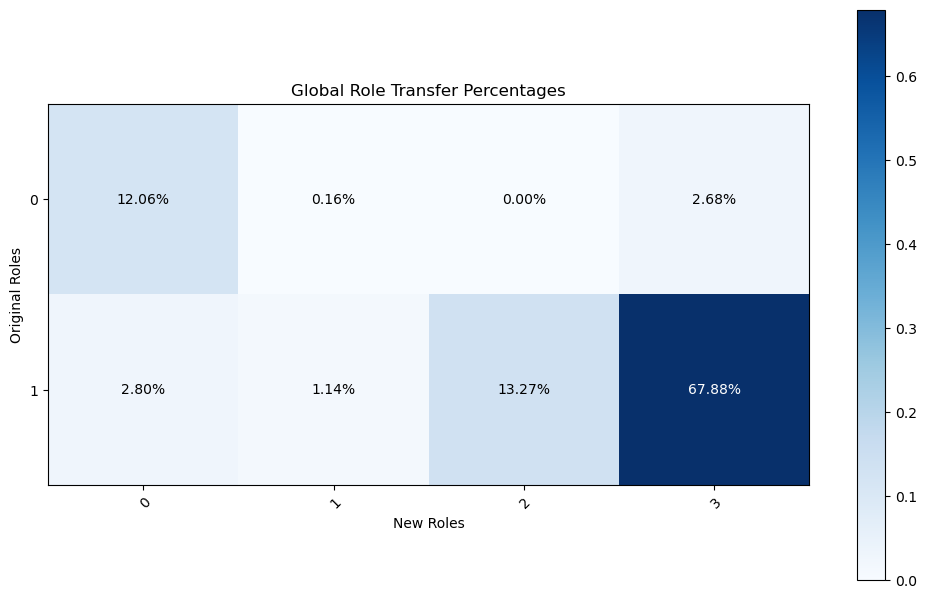

In [17]:
# Plot global role transfer percentages
plot_global_transfer(global_transfer)

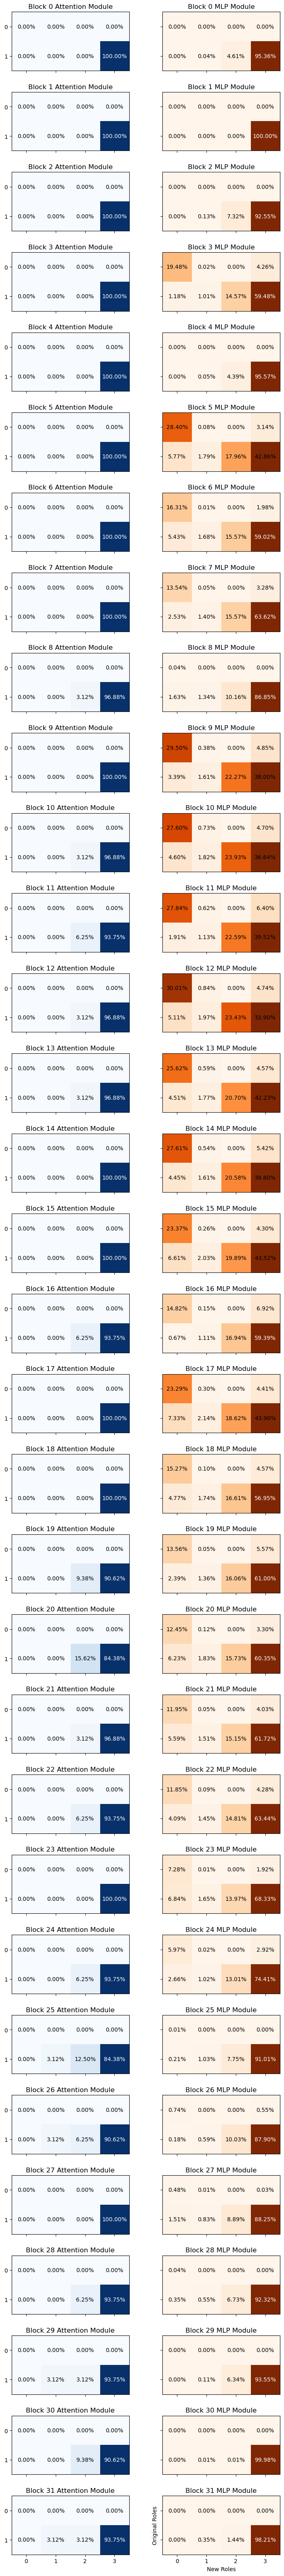

In [26]:
def plot_block_transfer(block_transfer_att, block_transfer_mlp):
    num_blocks = block_transfer_att.shape[0]
    fig, axes = plt.subplots(num_blocks, 2, figsize=(8, 2 * num_blocks), gridspec_kw={'width_ratios': [1, 1]}, sharex=True, sharey=True)

    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']

    if num_blocks == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one block

    for i in range(num_blocks):
        # Plot for Attention Module
        im_att = axes[i, 0].imshow(block_transfer_att[i].numpy(), cmap="Blues")
        axes[i, 0].set_xticks(np.arange(len(new_roles)))
        axes[i, 0].set_yticks(np.arange(len(roles)))
        axes[i, 0].set_xticklabels(new_roles)
        axes[i, 0].set_yticklabels(roles)
        axes[i, 0].set_title(f"Block {i} Attention Module")

        for j in range(len(roles)):
            for k in range(len(new_roles)):
                color = "white" if block_transfer_att[i, j, k] > 0.5 else "black"
                axes[i, 0].text(k, j, f'{block_transfer_att[i, j, k]:.2%}',
                                ha="center", va="center", color=color)

        # Plot for MLP Module
        im_mlp = axes[i, 1].imshow(block_transfer_mlp[i].numpy(), cmap="Oranges")
        axes[i, 1].set_xticks(np.arange(len(new_roles)))
        axes[i, 1].set_yticks(np.arange(len(roles)))
        axes[i, 1].set_xticklabels(new_roles)
        axes[i, 1].set_yticklabels(roles)
        axes[i, 1].set_title(f"Block {i} MLP Module")

        for j in range(len(roles)):
            for k in range(len(new_roles)):
                color = "white" if block_transfer_mlp[i, j, k] > 0.5 else "black"
                axes[i, 1].text(k, j, f'{block_transfer_mlp[i, j, k]:.2%}',
                                ha="center", va="center", color=color)

    fig.tight_layout(pad=2.0)
    plt.xlabel('New Roles')
    plt.ylabel('Original Roles')
    plt.show()

# Plot block level role transfer percentages
plot_block_transfer(block_transfer_att, block_transfer_mlp)

In [32]:
def plot_module_transfer(att_transfer, mlp_transfer):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']

    # Plot for Attention Module
    im_att = axes[0].imshow(att_transfer.numpy(), cmap="Blues")
    axes[0].set_xticks(np.arange(len(new_roles)))
    axes[0].set_yticks(np.arange(len(roles)))
    axes[0].set_xticklabels(new_roles)
    axes[0].set_yticklabels(roles)
    axes[0].set_title("Attention Module Global Role Transfer")
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if att_transfer[i, j] > 0.5 else "black"
            axes[0].text(j, i, f'{att_transfer[i, j]:.2%}', ha="center", va="center", color=color)
    plt.ylabel('Original Roles')

    # Plot for MLP Module
    im_mlp = axes[1].imshow(mlp_transfer.numpy(), cmap="Oranges")
    axes[1].set_xticks(np.arange(len(new_roles)))
    axes[1].set_yticks(np.arange(len(roles)))
    axes[1].set_xticklabels(new_roles)
    axes[1].set_yticklabels(roles)
    axes[1].set_title("MLP Module Global Role Transfer")
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if mlp_transfer[i, j] > 0.5 else "black"
            axes[1].text(j, i, f'{mlp_transfer[i, j]:.2%}', ha="center", va="center", color=color)

    # fig.tight_layout()
    plt.xlabel('New Roles')
    plt.show()

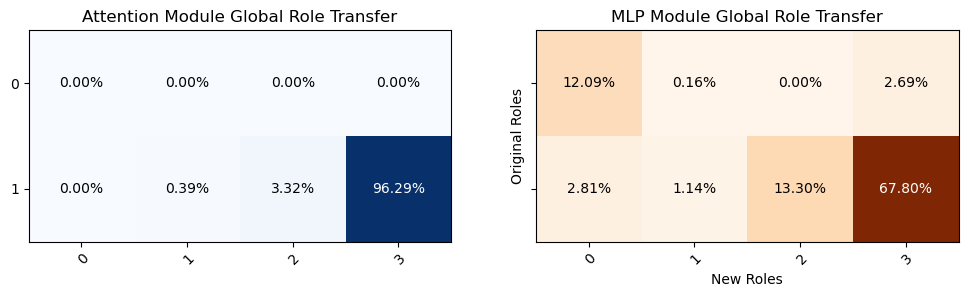

In [33]:
# Plot module level role transfer percentages
plot_module_transfer(att_transfer, mlp_transfer)